In [2]:
%load_ext autoreload
%autoreload 2

In [36]:
from itertools import islice
from datetime import datetime
from pathlib import Path

import joblib
import pandas as pd
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score

from plotting import (
    plot_confusion_matrix,
    plot_correct_prediction_counts,
    plot_sepsis_prediction_evolution, plot_combined_patient_data,
)

#### Load preprocessed splits

In [4]:
DATA_PATH = Path("../data")
SPLITS_PATH = DATA_PATH / "splits"

In [5]:
TARGET_COL = "SepsisLabel"
ID_COL = "Patient_ID"
TIME_COL = "ICULOS"

In [6]:
train_df = pd.read_parquet(SPLITS_PATH / "train.parquet", engine="pyarrow")
val_df   = pd.read_parquet(SPLITS_PATH / "val.parquet", engine="pyarrow")
test_df  = pd.read_parquet(SPLITS_PATH / "test.parquet", engine="pyarrow")

In [60]:
print(train_df.shape)
print(list(train_df.columns))

(1084561, 478)
['Patient_ID', 'Age', 'Gender', 'ICULOS', 'SepsisLabel', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Unit1', 'Unit2', 'HospAdmTime', 'HR_nan_mask', 'O2Sat_nan_mask', 'Temp_nan_mask', 'SBP_nan_mask', 'MAP_nan_mask', 'DBP_nan_mask', 'Resp_nan_mask', 'EtCO2_nan_mask', 'BaseExcess_nan_mask', 'HCO3_nan_mask', 'FiO2_nan_mask', 'pH_nan_mask', 'PaCO2_nan_mask', 'SaO2_nan_mask', 'AST_nan_mask', 'BUN_nan_mask', 'Alkalinephos_nan_mask', 'Calcium_nan_mask', 'Chloride_nan_mask', 'Creatinine_nan_mask', 'Bilirubin_direct_nan_mask', 'Glucose_nan_mask', 'Lactate_nan_mask', 'Magnesium_nan_mask', 'Phosphate_nan_mask', 'Potassium_nan_mask', 'Bilirubin_total_nan_mask', 'TroponinI_nan_mask', 

In [7]:
artifacts = joblib.load(DATA_PATH / "preprocess_artifacts.pkl")

In [8]:
feature_cols = [c for c in train_df.columns if c not in [TARGET_COL, ID_COL, TIME_COL]]

In [9]:
X_train = train_df[feature_cols]
y_train = train_df[TARGET_COL]

X_val = val_df[feature_cols]
y_val = val_df[TARGET_COL]

X_test = test_df.copy()
X_test_feat = test_df[feature_cols]
y_test = test_df[TARGET_COL]

#### Categorical Features

In [10]:
cat_feature_names = ["Gender"]

train_pool = Pool(X_train, y_train, cat_features=cat_feature_names or None)
val_pool = Pool(X_val, y_val, cat_features=cat_feature_names or None)

#### Calculate Positive Class Weight

In [11]:
pos_weight = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
class_weights = [1.0, pos_weight]

#### Model Params

In [12]:
# Best params after Param Grid
best_params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 10000,
    "od_type": "Iter",
    "od_wait": 150,
    "random_strength": 10,
    "learning_rate": 0.01,
    "depth": 6,
    "l2_leaf_reg": 3,
    "bagging_temperature": 1,
    "border_count": 128,
    "class_weights": class_weights,
    "random_state": 42,
    "task_type": "GPU",
    "metric_period": 1,
    "use_best_model": True,
}


#### Train

In [13]:
final_model = CatBoostClassifier(
    train_dir="../catboost/",
    **best_params
)
final_model.fit(train_pool, eval_set=val_pool, verbose=True)

0:	test: 0.7329766	best: 0.7329766 (0)	total: 103ms	remaining: 17m 11s
1:	test: 0.7476153	best: 0.7476153 (1)	total: 120ms	remaining: 10m 1s
2:	test: 0.7510680	best: 0.7510680 (2)	total: 138ms	remaining: 7m 40s
3:	test: 0.7508100	best: 0.7510680 (2)	total: 154ms	remaining: 6m 25s
4:	test: 0.7503423	best: 0.7510680 (2)	total: 171ms	remaining: 5m 42s
5:	test: 0.7506437	best: 0.7510680 (2)	total: 190ms	remaining: 5m 16s
6:	test: 0.7501415	best: 0.7510680 (2)	total: 207ms	remaining: 4m 56s
7:	test: 0.7526134	best: 0.7526134 (7)	total: 224ms	remaining: 4m 40s
8:	test: 0.7548980	best: 0.7548980 (8)	total: 243ms	remaining: 4m 29s
9:	test: 0.7558852	best: 0.7558852 (9)	total: 261ms	remaining: 4m 20s
10:	test: 0.7558538	best: 0.7558852 (9)	total: 278ms	remaining: 4m 12s
11:	test: 0.7561004	best: 0.7561004 (11)	total: 301ms	remaining: 4m 10s
12:	test: 0.7557305	best: 0.7561004 (11)	total: 325ms	remaining: 4m 9s
13:	test: 0.7555317	best: 0.7561004 (11)	total: 343ms	remaining: 4m 4s
14:	test: 0.75

In [14]:
now_str = datetime.now().strftime("%Y-%match-%d_%H-%M-%S")
final_model.save_model(f"../models/{now_str}-model.cbm")
print("Saved best model.")

Saved best model.


#### Test and Metrics

In [15]:
threshold = 0.5

In [16]:
test_probs = final_model.predict_proba(X_test_feat)[:, 1]
test_probs_s = pd.Series(test_probs, index=X_test.index, name="PredProb")
test_pred = (test_probs_s >= threshold).astype(int)

X_test_with_preds = X_test.copy()
X_test_with_preds["PredProb"] = test_probs_s

In [37]:
print(classification_report(y_test, test_pred))
print(roc_auc_score(y_test, test_pred))
print(average_precision_score(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.99      0.80      0.89    152424
           1       0.06      0.68      0.11      2773

    accuracy                           0.80    155197
   macro avg       0.53      0.74      0.50    155197
weighted avg       0.98      0.80      0.87    155197

0.743612704214972
0.04642471087537161


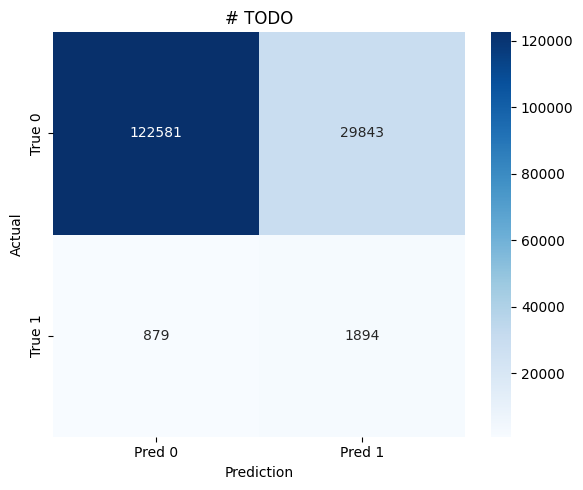

In [17]:
plot_confusion_matrix(confusion_matrix(y_test, test_pred))

In [19]:
positive_ids = (
    X_test_with_preds.groupby(ID_COL)[TARGET_COL]
          .max()
          .loc[lambda s: s == 1]
          .index
)

In [20]:
X_test_positive = X_test_with_preds[X_test_with_preds[ID_COL].isin(positive_ids)].copy()

In [21]:
X_test_positive["PredLabel"] = (
    (X_test_positive["PredProb"].to_numpy() > threshold).astype(int)
)

In [49]:
H: int = 0  # Nth patient hour, where SepsisLabel==1; {H ∈ ℤ : 0 <= H < L_min}, where L_min is the minimum patient sequence length

In [50]:
nth_sepsis_rows = (
    X_test_positive[X_test_positive[TARGET_COL] == 1]
    .sort_values([ID_COL, TIME_COL])
    .groupby(ID_COL, as_index=False)
    .nth(H)
    [[ID_COL, TIME_COL, TARGET_COL, "PredProb", "PredLabel"]]
)

In [51]:
patients_with_wrong_preds = nth_sepsis_rows.loc[nth_sepsis_rows["PredLabel"] == 0]["Patient_ID"]

In [52]:
wrong_preds_df = X_test_positive[
    X_test_positive["Patient_ID"].isin(patients_with_wrong_preds)
]

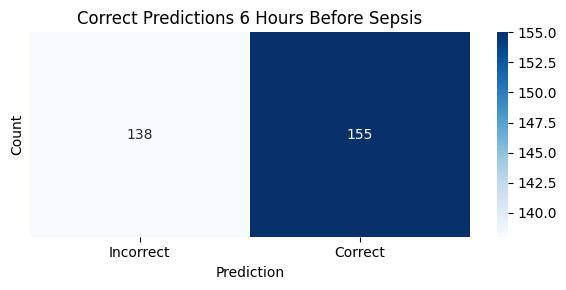

In [53]:
plot_correct_prediction_counts(nth_sepsis_rows["PredLabel"].to_numpy(), H)

In [ ]:
N = 10  # Amount of patients with incorrect predictions to display
for patient_id, patient_df in islice(wrong_preds_df.groupby(ID_COL), H):
    patient_df = patient_df.sort_values(TIME_COL)
    plot_sepsis_prediction_evolution(patient_df, patient_id=patient_id, threshold=threshold)
    plot_combined_patient_data(patient_df)

#### Export predictions to calculate Physionet 2019 Challenge score
**Note:** This score is not 100% accurate because the official scoring test dataset is not publicly available.

In [ ]:
PREDS_DIR = Path("../preds/")

LABEL_DIR = PREDS_DIR / "eval_labels/"
PRED_DIR = PREDS_DIR / "eval_preds/"

LABEL_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR.mkdir(parents=True, exist_ok=True)

for pid, pdf in X_test_with_preds.groupby("Patient_ID"):
    pdf = pdf.sort_values("ICULOS")

    label_df = pdf[["SepsisLabel"]].copy()
    label_path = LABEL_DIR / f"{pid}.psv"
    label_df.to_csv(label_path, sep='|', index=False)

    pred_df = pd.DataFrame({
        "PredictedProbability": pdf["PredProb"].values,
        "PredictedLabel": pdf["PredLabel"].values
    })
    pred_path = PRED_DIR / f"{pid}.psv"
    pred_df.to_csv(pred_path, sep='|', index=False)